In [7]:
import os
import sys
import pdb
import copy
import glob
import warnings
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.util as cutil
import metpy.constants as const
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib import colors
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append(os.path.abspath("/global/homes/j/jhollo/repos/climate_util"))
from PyTEMDiags import sph_zonal_averager
import climate_toolbox as ctb
import artist_utils as au

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE  = 9
MEDIUM_SIZE = 11
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

print('done')

done


In [6]:
# ==================================
# ========= read data ==============

print('reading ensemble...')
ens_members = sorted(glob.glob('/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members/ens*/*h2*.nc'))
ens_members = [xr.open_dataset(mem) for mem in ens_members]
ens_members = [mem.assign_coords(time = ctb.time2day(mem['time'])) for mem in ens_members]

time    = ens_members[0]['time']
lev     = ens_members[0]['lev']
datlat  = ens_members[0]['lat']
lat     = np.linspace(-90, 90, 181)
weights = xr.DataArray(np.cos(np.deg2rad(lat)), coords={'lat':lat})

sulf_q_mems = [mem['SULFATE'] for mem in ens_members]
z_mems      = [mem['Z3']/1000 for mem in ens_members]
v_mems      = [mem['V'] for mem in ens_members]

print('taking 30-day means...')
timeslice   = slice(240, 270)
sulf_q_mems = [mem.sel(time=timeslice).mean('time') for mem in sulf_q_mems]
z_mems      = [mem.sel(time=timeslice).mean('time') for mem in z_mems]
v_mems      = [mem.sel(time=timeslice).mean('time') for mem in v_mems]

print('getting zonal mean SULF...')
zm      = sph_zonal_averager(datlat, lat, L=70, debug=False)
zm.sph_compute_matrices()
sulf_q_mems = [zm.sph_zonal_mean(mem.T).T for mem in sulf_q_mems]

print('getting zonal mean V...')
v_mems = [zm.sph_zonal_mean(mem.T).T for mem in v_mems]

print('getting horizontal mean Z3...')
z_mems  = [zm.sph_zonal_mean(mem.T).T for mem in z_mems]
z_mems  = [mem.weighted(weights) for mem in z_mems]
z_mems  = [mem.mean('lat') for mem in z_mems]

print('getting ensemble mean SULF...')
sulf_q_em = xr.zeros_like(sulf_q_mems[0])
for i in range(len(sulf_q_mems)):
    sulf_q_em = sulf_q_em + sulf_q_mems[i]
sulf_q_em = sulf_q_em / len(sulf_q_mems)

print('getting ensemble mean SULF...')
v_em = xr.zeros_like(v_mems[0])
for i in range(len(v_mems)):
    v_em = v_em + v_mems[i]
v_em = v_em / len(v_mems)

print('getting ensemble mean Z3...')
z_em = xr.zeros_like(z_mems[0])
for i in range(len(z_mems)):
    z_em = z_em + z_mems[i]
z_em = z_em / len(z_mems)

print('done')

reading ensemble...
taking 30-day means...
getting zonal mean SULF...
getting zonal mean V...
getting horizontal mean Z3...
getting ensemble mean SULF...
getting ensemble mean SULF...
getting ensemble mean Z3...
done


In [3]:
# ===============================================
# ========= read supplemental data ==============

print('reading ensemble rerun...')
ens_members = sorted(glob.glob('/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/extra_outputs_for_hsw_paper/ens_members/*541day*ens*/run/*.h2.*.nc'))
ens_members = [xr.open_dataset(mem) for mem in ens_members]
ens_members = [mem.assign_coords(time = ctb.time2day(mem['time'])) for mem in ens_members]

trop_mems    = [mem['TROP_P']/100 for mem in ens_members]
attensw_mems = [mem['ATTEN_SW'] for mem in ens_members]
attenlw_mems = [mem['ATTEN_LW'] for mem in ens_members]
heat_mems    = [mem['SAI_HEAT'] for mem in ens_members]

print('taking 30-day means...')
trop_mems    = [mem.sel(time=timeslice).mean('time') for mem in trop_mems]
attensw_mems = [mem.sel(time=timeslice).mean('time') for mem in attensw_mems]
attenlw_mems = [mem.sel(time=timeslice).mean('time') for mem in attenlw_mems]
heat_mems    = [mem.sel(time=timeslice).mean('time') for mem in heat_mems]

print('getting zonal mean TROP...')
trop_mems    = [zm.sph_zonal_mean(mem.T).T for mem in trop_mems]
print('getting zonal mean ATTEN...')
attensw_mems = [zm.sph_zonal_mean(mem.T).T for mem in attensw_mems]
attenlw_mems = [zm.sph_zonal_mean(mem.T).T for mem in attenlw_mems]
print('getting zonal mean HEAT...')
heat_mems    = [zm.sph_zonal_mean(mem.T).T for mem in heat_mems]

print('getting ensemble mean TROP...')
trop_em = xr.zeros_like(trop_mems[0])
for i in range(len(trop_mems)):
    trop_em = trop_em + trop_mems[i]
trop_em = trop_em / len(trop_mems)
print('getting ensemble mean ATTEN...')
attensw_em = xr.zeros_like(attensw_mems[0])
for i in range(len(attensw_mems)):
    attensw_em = attensw_em + attensw_mems[i]
attensw_em = attensw_em / len(attensw_mems)
attenlw_em = xr.zeros_like(attenlw_mems[0])
for i in range(len(attenlw_mems)):
    attenlw_em = attenlw_em + attenlw_mems[i]
attenlw_em = attenlw_em / len(attenlw_mems)
print('getting ensemble mean HEAT...')
heat_em = xr.zeros_like(heat_mems[0])
for i in range(len(heat_mems)):
    heat_em = heat_em + heat_mems[i]
heat_em = heat_em / len(heat_mems)

print('done')

reading ensemble rerun...
taking 30-day means...
getting zonal mean TROP...
getting zonal mean ATTEN...
getting zonal mean HEAT...
getting ensemble mean TROP...
getting ensemble mean ATTEN...
getting ensemble mean HEAT...
done


In [24]:
# ===========================================
# ========= computing streamfunction ========

print('computing Stoeks streamfunction...')

psi_em = np.zeros(v_em.shape)
for k in range(len(lev)):
    int_v = np.trapz(v_em[:k+1,:], lev[:k+1]*100, axis=0)
    psi_em[k,:] = (2*np.pi * const.Re * np.cos(np.deg2rad(lat)))/const.g * int_v

print('done')

computing Stoeks streamfunction...
done


array([-4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  , -2.75, -2.5 ,
       -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,
        0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25])

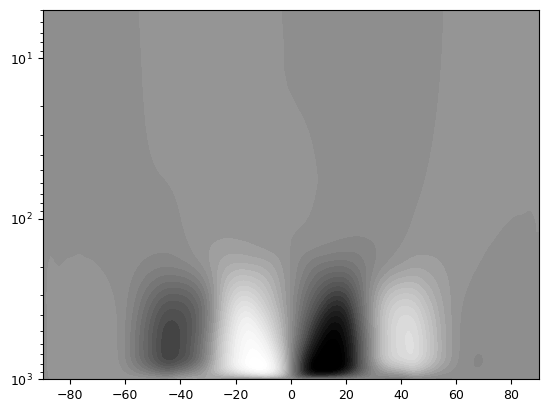

In [81]:
LAT, LEV = np.meshgrid(lat, lev)
levels = np.arange(-4.5, 4.5, 0.25)
plt.contourf(LAT, LEV, psi_em/2e10, levels=levels, cmap='Greys', extend='both')
plt.ylim([5, 1000])
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
plt.show()

In [168]:
np.setdiff1d([1, 2, 3], [2])

array([1, 3])

/global/homes/j/jhollo/miniconda3/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


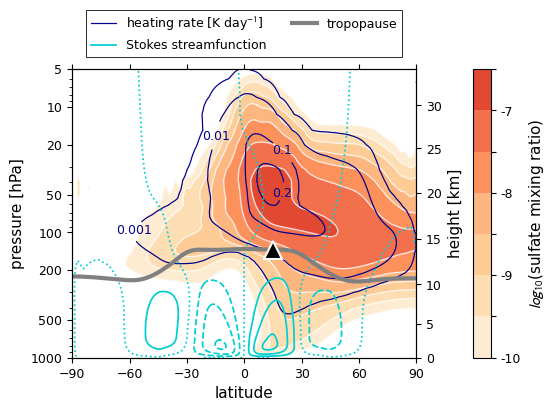

In [171]:
# =============================================
# ===============  plotting  ==================

LAT, LEV = np.meshgrid(lat, lev)

fig   = plt.figure(figsize=(5.75, 4.25))
ax1   = fig.add_subplot(111)

erupt_lat  = 15.15 
erupt_lev  = 139.58

# ------------------------------------

Qcmap   = plt.cm.OrRd
Qlw     = 1
Qccolor = 'w'
Qcalpha = 0.8
Qlevels = np.arange(-10, -6.49, 0.5)
cbarlabels  = list(Qlevels)
for i in range(len(cbarlabels)):
    l = Qlevels[i]
    if(np.isclose((l*10)%10, 0)): 
        cbarlabels[i] = '{:.0f}'.format(np.around(l, decimals=1))
    else: 
        cbarlabels[i] = ' '

Ocolor    = 'darkblue'
Olw       = 0.88
Oalpha    = 1
Ovar      = heat_em
Olevels   = np.hstack([[0.001], np.arange(0.01, 0.2, 0.05)])
Olevels   = [0.001, 0.01, 0.1, 0.2]
Olabpos   = [[-72, 25], [-15, 15], [20, 20], [20, 50]]
Olabrot   = [0, 0, 0, 0]
Olabspace = [-10, -10, -1, -6.5]
Olabel    = r'heating rate [K day$^{-1}$]'
Ols       = '-'

Plevels = np.arange(-9, 9.1, 3)
Pcolor = 'darkturquoise'
Plw = 1.25
Pls0 = ':'
Palpha=1
Plabel = 'Stokes streamfunction'
        
troplw = 3
tropcolor = 'grey'

latlim    = [-90, 90]
latticks  = [-90, -60, -30, 0, 30, 60, 90]
#latticks = np.arange(-90, 91, 10)
levlim    = [5, 1000]
levticks  = [1000, 500, 200, 100, 50, 20, 10, 5]

cf  = ax1.contourf(LAT, LEV, np.log10(sulf_q_em), cmap=Qcmap, levels=Qlevels, vmax=np.max(Qlevels)*0.8, vmin=np.min(Qlevels)*1.02)
cfl = ax1.contour(LAT, LEV, np.log10(sulf_q_em), levels=Qlevels, colors=Qccolor, alpha=Qcalpha, linewidths=Qlw, linestyles='-')
cfl2 = ax1.contour(LAT, LEV, Ovar, levels=Olevels, colors=Ocolor, linewidths=Olw, linestyles=Ols, alpha=Oalpha)
cflpsi = ax1.contour(LAT, LEV, psi_em/1e10, levels=np.setdiff1d(Plevels, [0]), colors=Pcolor, linewidths=Plw, alpha=Palpha)
cflpsi = ax1.contour(LAT, LEV, psi_em/1e10, levels=[0], colors=Pcolor, linestyles=Pls0, linewidths=Plw, alpha=Palpha)

ax1.plot([0], [-1000], ls=Ols, color=Ocolor, lw=Olw, alpha=Oalpha, label=Olabel) # dummy
ax1.plot([0], [-1000], ls=Pls, color=Pcolor, lw=Plw, alpha=Palpha, label=Plabel) # dummy

ax1.plot(lat, trop_em, '-', color=tropcolor, lw=troplw, label='tropopause')
ax1.plot(erupt_lat, erupt_lev, '^k', ms=13, mew=1.5, mec='w')
ax1.plot(-erupt_lat, -erupt_lev, '^k', ms=6) # dummy
#ax1.axvline(0, linestyle=':', color='k', linewidth=1.5, alpha=0.3)

cbar = fig.colorbar(cf, ax=ax1, orientation='vertical', location='right', extendfrac=0.025,
                    aspect=16, extend='both', extendrect=False, pad=0.12)
cbar.set_label(r'$\mathit{log}_{10}$(sulfate mixing ratio)')
cbar.ax.set_yticks(cf.levels, labels=cbarlabels)

for i in range(len(Olabspace)):
    labs = ax1.clabel(cfl2, inline=True, fontsize=SMALL_SIZE, manual=[Olabpos[i]], 
                      inline_spacing=Olabspace[i], fmt=lambda x: '{:.3g}'.format(x))
for i in range(len(labs)):
    labs[i].set_rotation(Olabrot[i])
     
ax1.set_xticks(latticks)
ax1.set_xlim(latlim)
ax1.set_xlabel('latitude')
ax1.set_ylim(levlim)
ax1.set_ylabel('pressure [hPa]')
ax1.set_yscale('log')
ax1.invert_yaxis()
ax1.tick_params(top=True, bottom=True, left=True, right=True, 
                labelleft=True, labelright=False, labeltop=False, labelbottom=True, which='both')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y,pos: \
                             ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_yticks(levticks)

ax1z = ax1.twinx()
ax1z.set_yscale('log')
zyticks_z = np.arange(0, 61, 5)
zyticks_p = np.interp(zyticks_z, z_em[::-1], lev[::-1])
ax1z.set_yticks(zyticks_p, labels=zyticks_z)
ax1z.set_ylim(levlim)
ax1z.invert_yaxis()
ax1z.tick_params(right=False, which='minor')
ax1z.set_ylabel('height [km]')

#ax1.grid()

leg = ax1.legend(ncol=2, fancybox=False, shadow=False, frameon=True, 
                 loc='lower center', bbox_to_anchor=(0.5, 1.02))
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.75)

# ------------------------------------------

plt.tight_layout()
fig.savefig('figs/LW_heating.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [172]:
Plevels

array([-9., -6., -3.,  0.,  3.,  6.,  9.])